In [125]:
#reading in IMDB sample FIle
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
#Loading the File
df = spark.read.parquet('imdb_reviews_preprocessed.parquet')
df.show(5)

+---------+--------------------+-----+
|       id|              review|score|
+---------+--------------------+-----+
|pos_10006|In this "critical...|  1.0|
|pos_10013|Like one of the p...|  1.0|
|pos_10022|Aro Tolbukhin bur...|  1.0|
|pos_10033|The movie Titanic...|  1.0|
| pos_1003|Another Aussie ma...|  1.0|
+---------+--------------------+-----+
only showing top 5 rows



In [110]:
import pyspark.sql.functions as fn
from pyspark.ml import feature,Pipeline,classification

from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StopWordsRemover
#Converts the word/Para column to word list ; Setpattern signifies all special characters removed.
token = feature.RegexTokenizer().setInputCol('review').setOutputCol('words').setPattern('\\p{L}+').setGaps(False)

#Splitting to Train & Test
train , test = df.randomSplit([0.7,0.3],0)



import requests
#Getting stopwords from this link and using it on the tokenized column to remove the stop words
link = 'http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words'
stopwords = requests.get(link).text.split()
stopwordsremover = feature.StopWordsRemover().setStopWords(stopwords).setCaseSensitive(False).setInputCol('words').setOutputCol('Filtered')

#Gives the term frequency of the words in the word column
count_vector = feature.CountVectorizer().setInputCol('Filtered').setOutputCol('tf')

#Gives the idf score of those words in the tf column(Calculated as per formula) - so most frequently used words gets lesser weights
tfidf = feature.IDF().setInputCol('tf').setOutputCol('tfidf')

#initializing the Logistic Regression model with elastic and lambda param
lr = classification.LogisticRegression().setLabelCol('score').setRawPredictionCol('Predicted').setElasticNetParam(.3).setRegParam(.02).setFeaturesCol('tfidf')

evaluator = BinaryClassificationEvaluator().setLabelCol('score').setRawPredictionCol(lr.getRawPredictionCol())

# param_grid = ParamGridBuilder().addGrid(lr.regParam,[0.1,.01]).addGrid(lr.elasticNetParam,[0,.2,.5]).build()

model_pipe = Pipeline(stages = [token,stopwordsremover,count_vector,tfidf,lr])

#Perform CV if required
# cv = CrossValidator(estimator = model_pipe,
#                    estimatorParamMaps = param_grid,
#                    numFolds = 2,
#                    evaluator = evaluator)

tranformed = model_pipe.fit(train)
# cv_tranformed = cv.fit(train)
tranformed_test = tranformed.transform(test)

In [135]:
import pandas as pd
from pyspark.sql.types import *

en_weights = tranformed.stages[-1].coefficients.toArray()
en_coeffs_df = pd.DataFrame({'word': tranformed.stages[2].vocabulary, 'weight': en_weights})
#Printing the words and their contribution to the prediction of sentiment.
#As expected, words like worst,waste contribute heavily to the negative review.
en_coeffs_df.sort_values('weight').head(15)

,word,weight
102,worst,-0.397483
278,waste,-0.358427
211,awful,-0.269664
11,bad,-0.235873
617,poorly,-0.209678
181,boring,-0.207001
1049,disappointment,-0.204845
269,worse,-0.187626
48842,prologic,-0.185930
42113,flesheaters,-0.185930


THE AUC score is 0.94


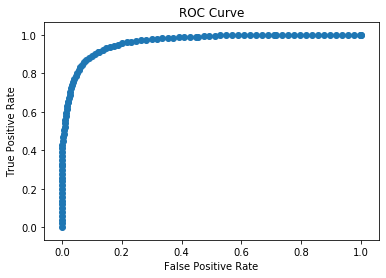

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
#The below prints the AUC score of the Logistic regression model
print("THE AUC score is %.2f"%evaluator.evaluate(tranformed.transform(test)))
#Printing the ROCK' curve
ROCK = tranformed.stages[-1].summary.roc.toPandas()
plt.scatter(ROCK['FPR'],ROCK['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
display()

#Since its leaning towards the left more, This model is good.(Also the AUC score looks solid enough)

In [134]:
#For Confu'sion' - 'sea yon' matrix
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import *
# https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score-Thanks..!
# ConfusionMatrix() works only with RDDs, so we will have to convert our DataFrame of (prediction, label) into a RDD.
y_true = tranformed_test.select(['score']).collect()
y_pred = tranformed_test.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

pred_label = tranformed_test.select(['prediction','score'])
metrics = MulticlassMetrics(pred_label.rdd.map(lambda x: (x[0],x[1])))

print(metrics.confusionMatrix())

# From this confusion matrix ; 
tp,fn,fp,tn = metrics.confusionMatrix().values
print('Accuracy : %.2f'%((tp+tn)/(tp+tn+fp+fn)))
print('TPR = %.2f'%(tp/(tp+fn)))

              precision    recall  f1-score   support

         0.0       0.89      0.84      0.87      3792
         1.0       0.85      0.90      0.87      3730

    accuracy                           0.87      7522
   macro avg       0.87      0.87      0.87      7522
weighted avg       0.87      0.87      0.87      7522

DenseMatrix([[3190.,  602.],
             [ 384., 3346.]])
Accuracy : 0.87
TPR = 0.89


In [117]:
#The TPR signifying that this model correctly classifies the positive outcomes with 89%accuracy
print('TPR = %.2f'%(tp/(tp+fn)))
#The FPR signifying that this model correctly classifies the negative outcomes with 85%accuracy
print('FPR = %.2f'%(tn/(tn+fp)))

TPR = 0.89
FPR = 0.85
